In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install openpyxl


   ---------------------------------------- 0/2 [et-xmlfile]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [open

In [6]:
# ============================================================
# CRISP-DM PARA FORECAST HOTELERO
# Dataset: Hotel_database.xlsx
# ============================================================

# =========================
# 0. LIBRERÍAS
# =========================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")

Matplotlib is building the font cache; this may take a moment.


In [7]:
#BUSINESS UNDERSTANDING

"""
OBJETIVO DE NEGOCIO:
Predecir variables clave del hotel (demanda, ingresos, pick-up, etc.)
para apoyar decisiones de:
- Pricing
- Inventory
- Distribución
- Revenue Management

PREGUNTAS CLAVE:
- ¿Qué variables impactan más en el forecast?
- ¿Qué tan anticipable es la demanda?
- ¿Dónde fallan los modelos?
"""


'\nOBJETIVO DE NEGOCIO:\nPredecir variables clave del hotel (demanda, ingresos, pick-up, etc.)\npara apoyar decisiones de:\n- Pricing\n- Inventory\n- Distribución\n- Revenue Management\n\nPREGUNTAS CLAVE:\n- ¿Qué variables impactan más en el forecast?\n- ¿Qué tan anticipable es la demanda?\n- ¿Dónde fallan los modelos?\n'

In [9]:
path = r"C:\Users\34608\OneDrive\Desktop\Hotel_database_2026.xlsx"

df = pd.read_excel(path, sheet_name="Database")
diccionario = pd.read_excel(path, sheet_name="Feature_description")

print("Shape:", df.shape)
df.head()


Shape: (883, 206)


,DATE,PtS,AvRooms,EVENT,IMPACT,EvtImp_RN,EvtImp_RP,EvtImp_FBP,EvtImp_TREV,curva_RNt-01,...,OTB_EVENTS_PYW,OTB_OTHERS_PYW,OTB_BKF_PYN,OTB_FB_PYN,OTB_EVENTS_PYN,OTB_OTHERS_PYN,Projected_pred_BKF,Projected_pred_FB,Projected_pred_EVENTS,Projected_pred_OTHERS
0,2023-08-01,60,183,0,0,1.0,1.0,1.0,1.0,7,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1,2023-08-02,60,183,0,0,1.0,1.0,1.0,1.0,4,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,2023-08-03,60,183,0,0,1.0,1.0,1.0,1.0,5,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,2023-08-04,60,183,0,0,1.0,1.0,1.0,1.0,7,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4,2023-08-05,60,183,0,0,1.0,1.0,1.0,1.0,10,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [10]:
targets = [c for c in df.columns if c.endswith("RN_000")]

print("Variables target:")
targets

Variables target:


['RN_000']

In [11]:
df.dtypes.value_counts()

float64           146
int64              59
datetime64[us]      1
Name: count, dtype: int64

In [12]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")

C:\Users\34608\AppData\Local\Temp\ipykernel_28368\1261082020.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Year'] = df['DATE'].dt.year
C:\Users\34608\AppData\Local\Temp\ipykernel_28368\1261082020.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Week'] = df['DATE'].dt.isocalendar().week  # Número de semana (1-53)


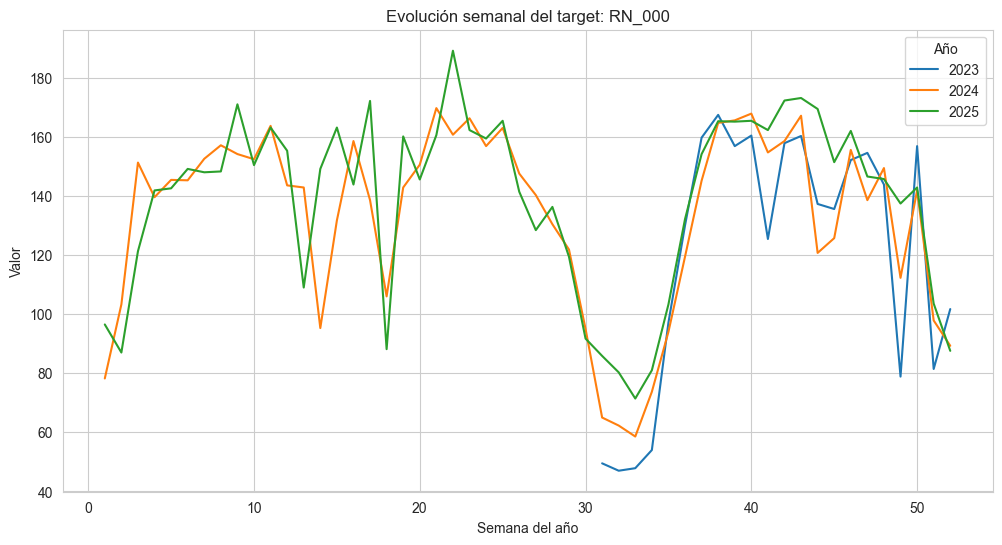

In [13]:
target_example = targets[0]


# Asegurarnos de que DATE es datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Extraer año y semana del año
df['Year'] = df['DATE'].dt.year
df['Week'] = df['DATE'].dt.isocalendar().week  # Número de semana (1-53)

target_example = targets[0]

plt.figure(figsize=(12,6))

# Iteramos por cada año y graficamos
for year in sorted(df['Year'].unique()):
    df_year = df[df['Year'] == year]
    
    # Agrupar por semana
    weekly = df_year.groupby('Week')[target_example].mean()  # promedio por semana
    plt.plot(weekly.index, weekly.values, label=str(year))

plt.title(f"Evolución semanal del target: {target_example}")
plt.xlabel("Semana del año")
plt.ylabel("Valor")
plt.legend(title="Año")


In [22]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(10)

Series([], dtype: float64)

In [23]:
features = [
    c for c in df.columns
    if c not in targets and c not in ["DATE"]
]

X = df[features]
y = df[target_example]

In [16]:
corr = df[features + [target_example]].corr()[target_example].sort_values(ascending=False)

corr.head(150)

NameError: name 'features' is not defined

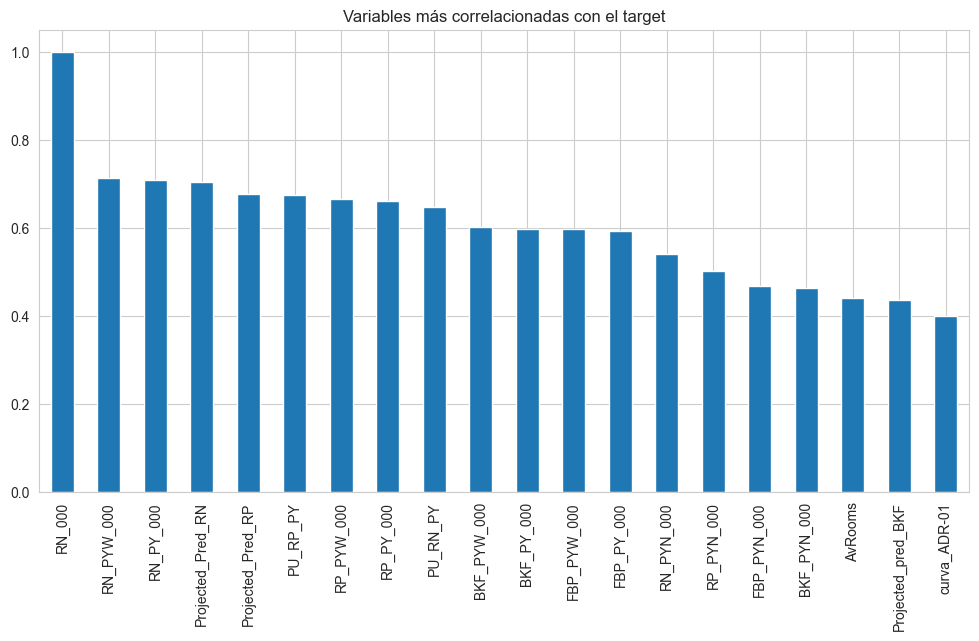

In [ ]:
corr.head(20).plot(kind="bar")
plt.title("Variables más correlacionadas con el target")
plt.show()
#segun el valor es el porcentaje de correlacion

In [26]:
top_features = corr.head(20).index.drop(target_example)
X = df[top_features]

In [27]:
split_date = df["DATE"].quantile(0.8)

train = df[df["DATE"] <= split_date]
test  = df[df["DATE"] > split_date]

X_train = train[top_features]
y_train = train[target_example]

X_test = test[top_features]
y_test = test[target_example]

In [28]:
baseline_pred = y_train.mean()
baseline_test = np.repeat(baseline_pred, len(y_test))

print("MAE baseline:", mean_absolute_error(y_test, baseline_test))

MAE baseline: 35.720338983050844


In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("MAE Linear:", mean_absolute_error(y_test, pred_lr))

MAE Linear: 22.354603843607233


In [30]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("MAE RF:", mean_absolute_error(y_test, pred_rf))


MAE RF: 17.74971420993316


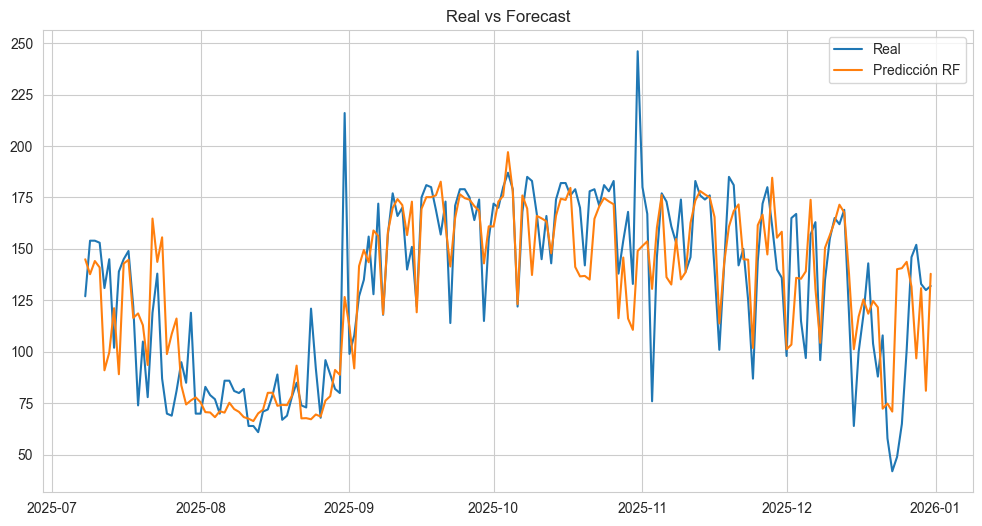

In [31]:
plt.plot(test["DATE"], y_test.values, label="Real")
plt.plot(test["DATE"], pred_rf, label="Predicción RF")
plt.legend()
plt.title("Real vs Forecast")
plt.show()

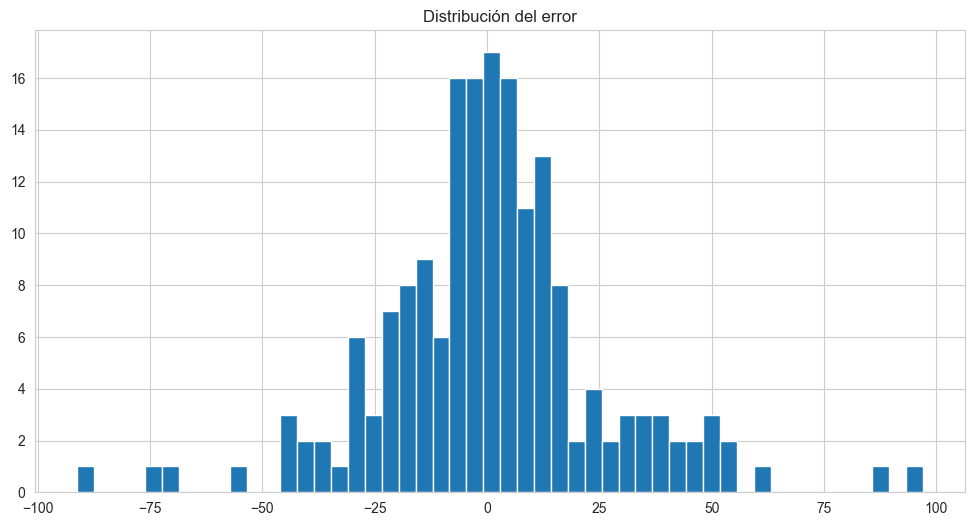

In [32]:
errors = y_test - pred_rf

plt.hist(errors, bins=50)
plt.title("Distribución del error")
plt.show()

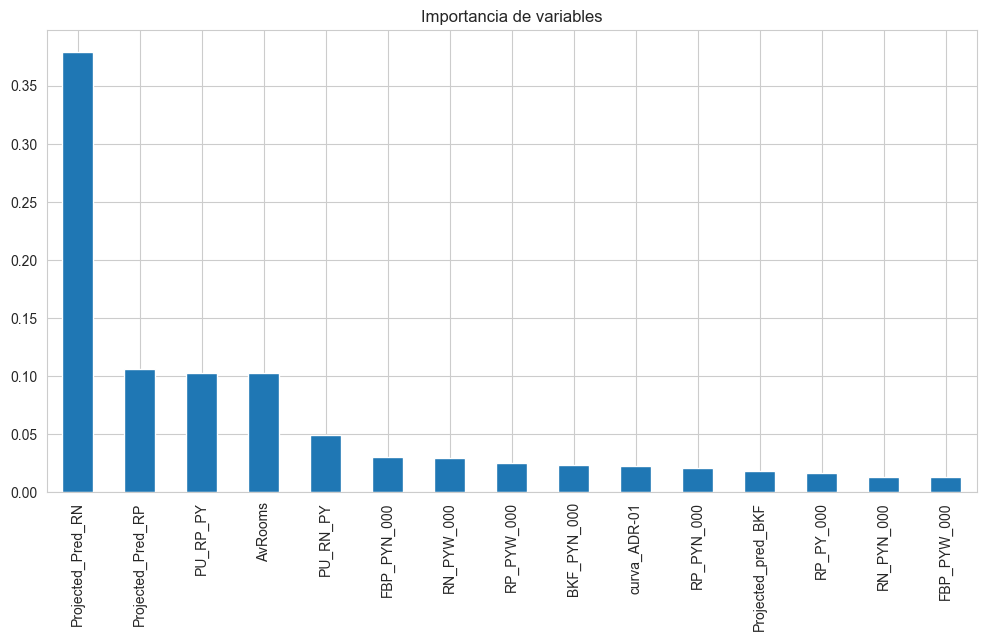

In [33]:
imp = pd.Series(rf.feature_importances_, index=top_features).sort_values(ascending=False)

imp.head(15).plot(kind="bar")
plt.title("Importancia de variables")
plt.show()